In [17]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
import folium
import os

LOCATION_CITY = "Luton, UK"
LOCATION_COORDS = [51.8797, -0.4175] # Latitude, Longitude for Luton


def generate_sample_data():

    print("Generating sample data for the last 365 days...")
    dates = pd.to_datetime(pd.date_range(end=pd.Timestamp.today(), periods=365, freq='D'))

    aq_data = {
        'date': dates,
        'location': LOCATION_CITY,
        'pm25': 25 + 10 * np.sin(np.arange(365) * 2 * np.pi / 365) + np.random.rand(365) * 15,
        'pm10': 40 + 15 * np.sin(np.arange(365) * 2 * np.pi / 365) + np.random.rand(365) * 20,
        'no2': 30 + 12 * np.sin(np.arange(365) * 2 * np.pi / 365 + np.pi/2) + np.random.rand(365) * 10
    }
    air_quality_df = pd.DataFrame(aq_data)

    weather_data = {
        'date': dates,
        'temperature_c': 15 + 10 * np.cos(np.arange(365) * 2 * np.pi / 365) + np.random.rand(365) * 5,
        'humidity_percent': 60 - 20 * np.cos(np.arange(365) * 2 * np.pi / 365) + np.random.rand(365) * 10,
        'wind_speed_kmh': 15 + np.random.rand(365) * 10
    }
    weather_df = pd.DataFrame(weather_data)

    for df in [air_quality_df, weather_df]:
        for col in df.columns:
            if df[col].dtype != '<M8[ns]>':
                df.loc[df.sample(frac=0.05).index, col] = np.nan

    print("Sample data generation complete.")
    return air_quality_df, weather_df

In [18]:
def clean_and_prepare_data(aq_df, weather_df):
    print("Cleaning and preparing data...")
    df = pd.merge(aq_df, weather_df, on='date', how='outer')
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    print("Data cleaning and preparation complete.")
    return df

Generating sample data for the last 365 days...
Sample data generation complete.
Cleaning and preparing data...
Data cleaning and preparation complete.


/tmp/ipython-input-1795239469.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/tmp/ipython-input-1795239469.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


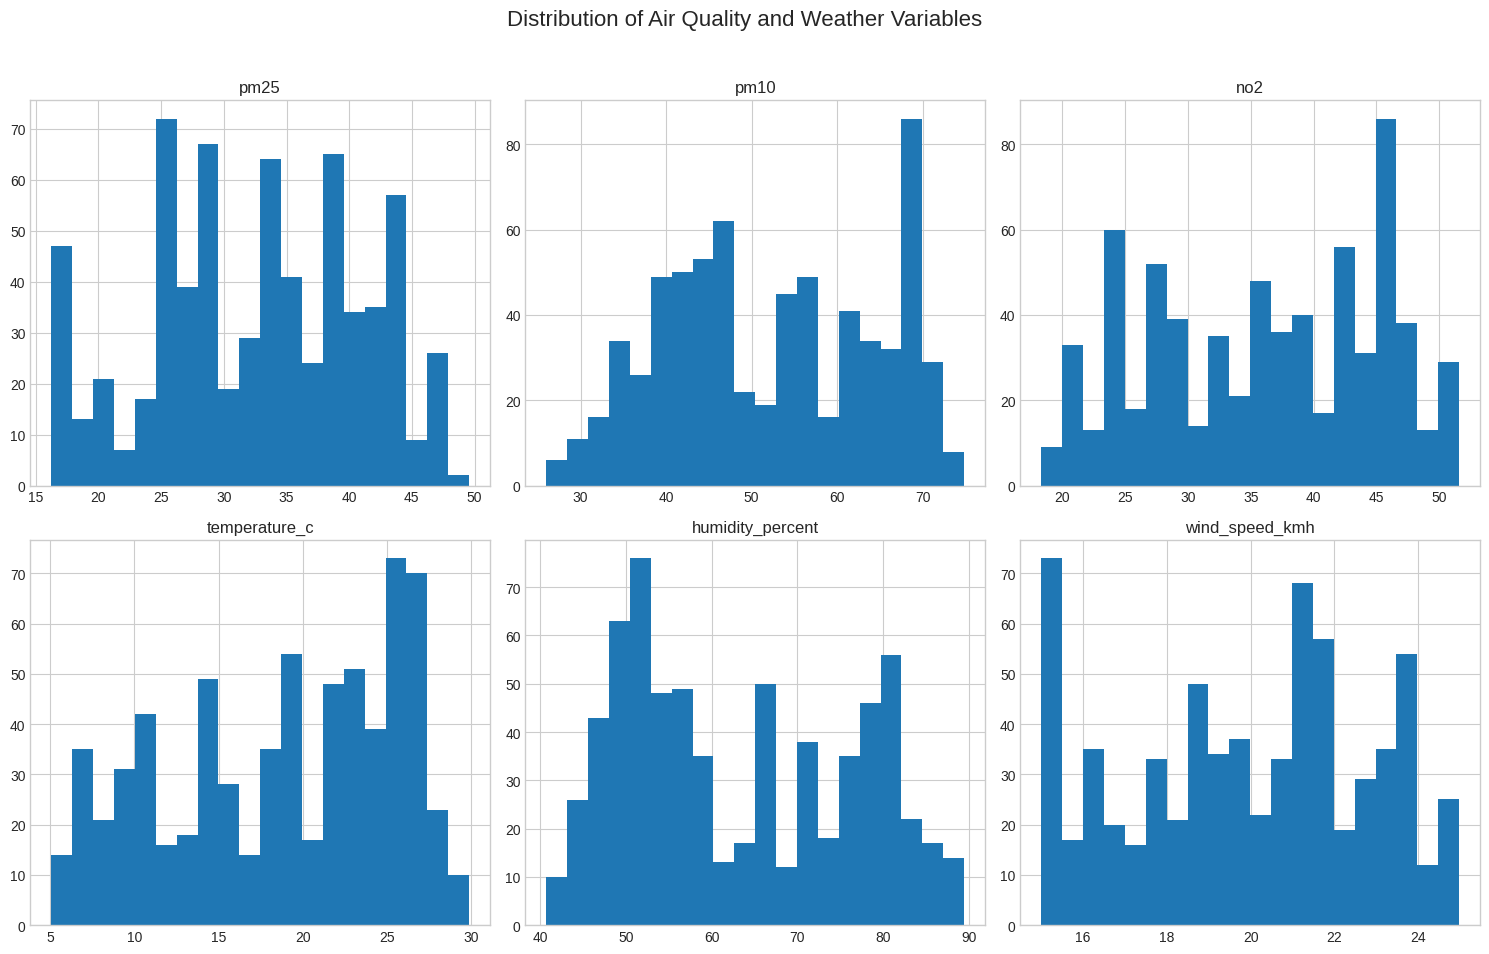

/tmp/ipython-input-2860945907.py:28: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Liberation Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.96])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


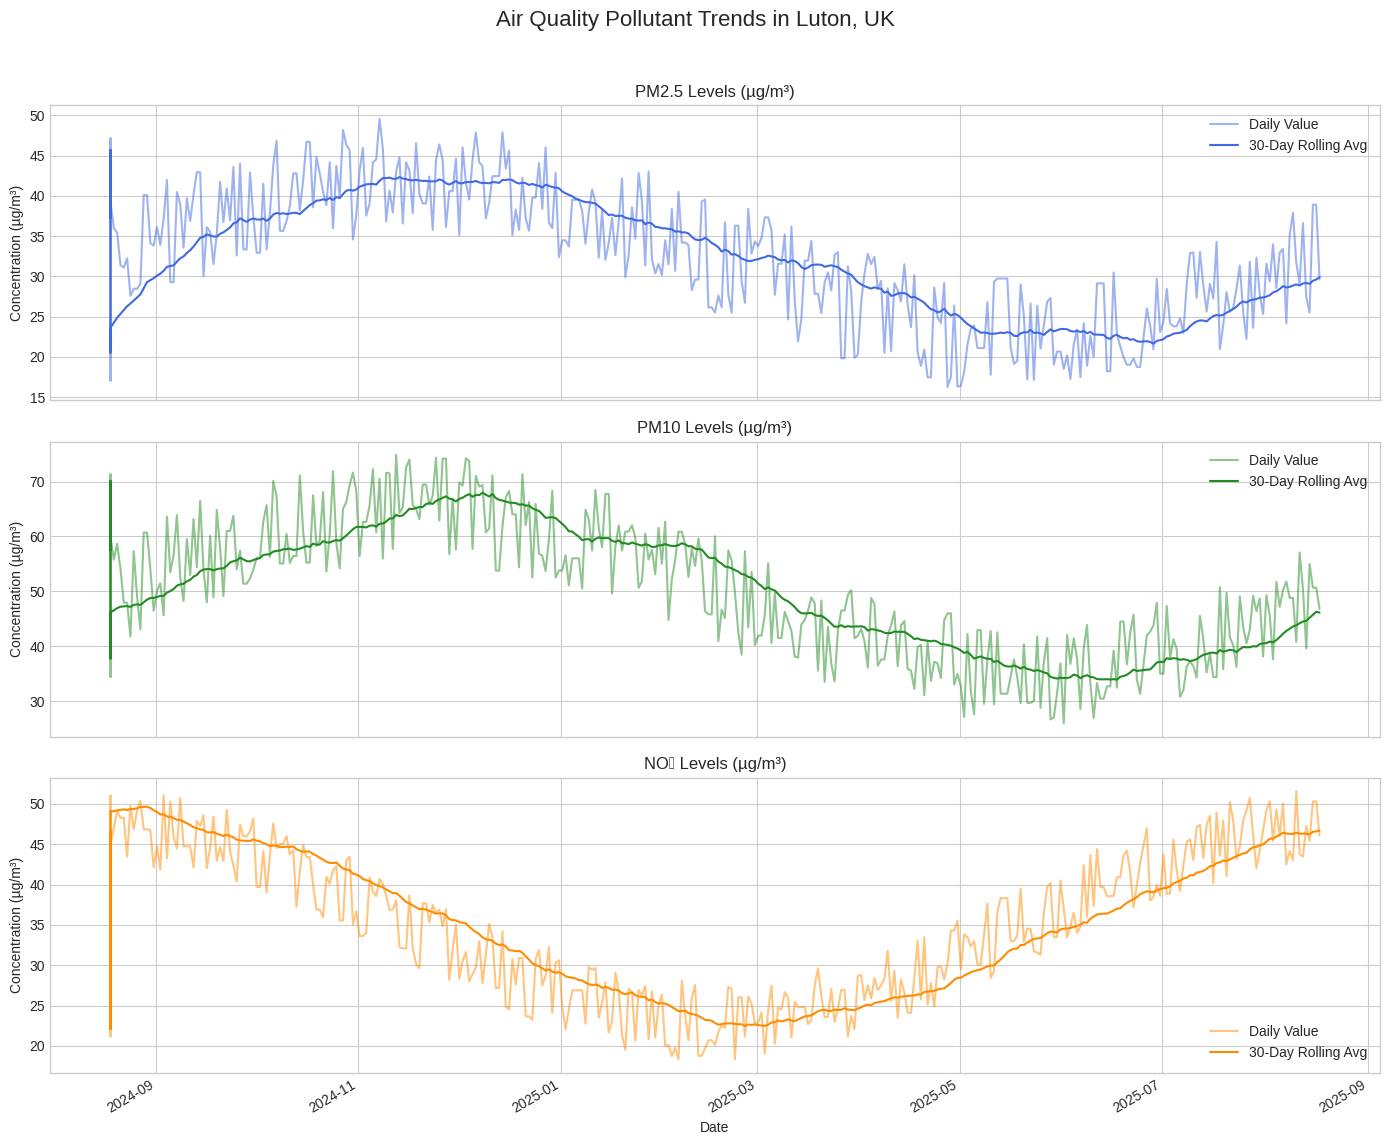

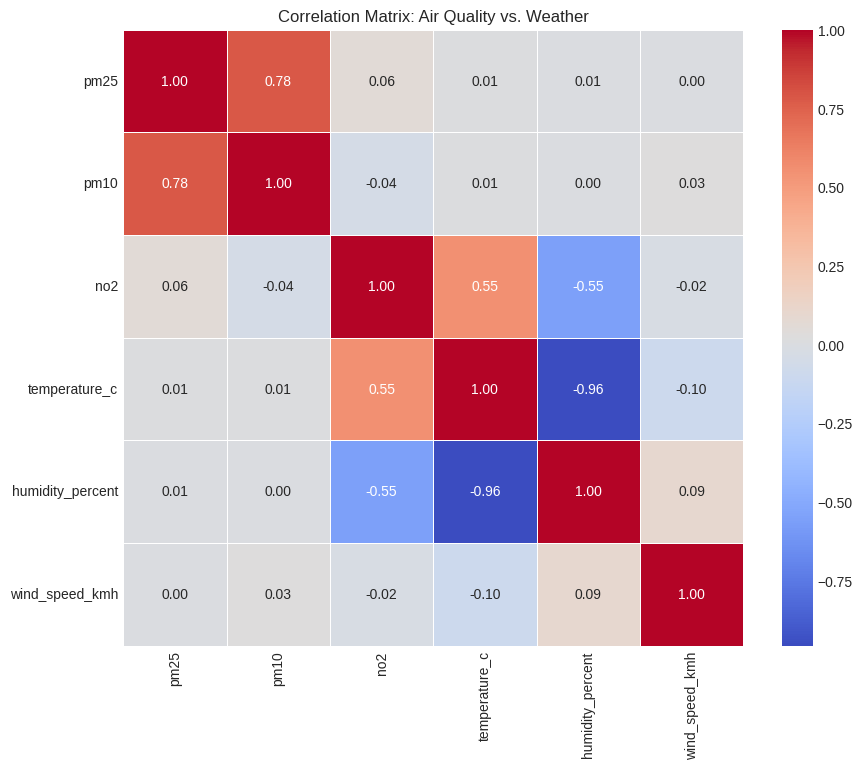

/tmp/ipython-input-2860945907.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month', y='pm25', data=df_monthly, ax=axes[0], palette='viridis').set_title('PM2.5')
/tmp/ipython-input-2860945907.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month', y='pm10', data=df_monthly, ax=axes[1], palette='plasma').set_title('PM10')
/tmp/ipython-input-2860945907.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month', y='no2', data=df_monthly, ax=axes[2], palette='magma').set_title('NO₂')
/tmp/ipython-input-2860945907.py:51: User

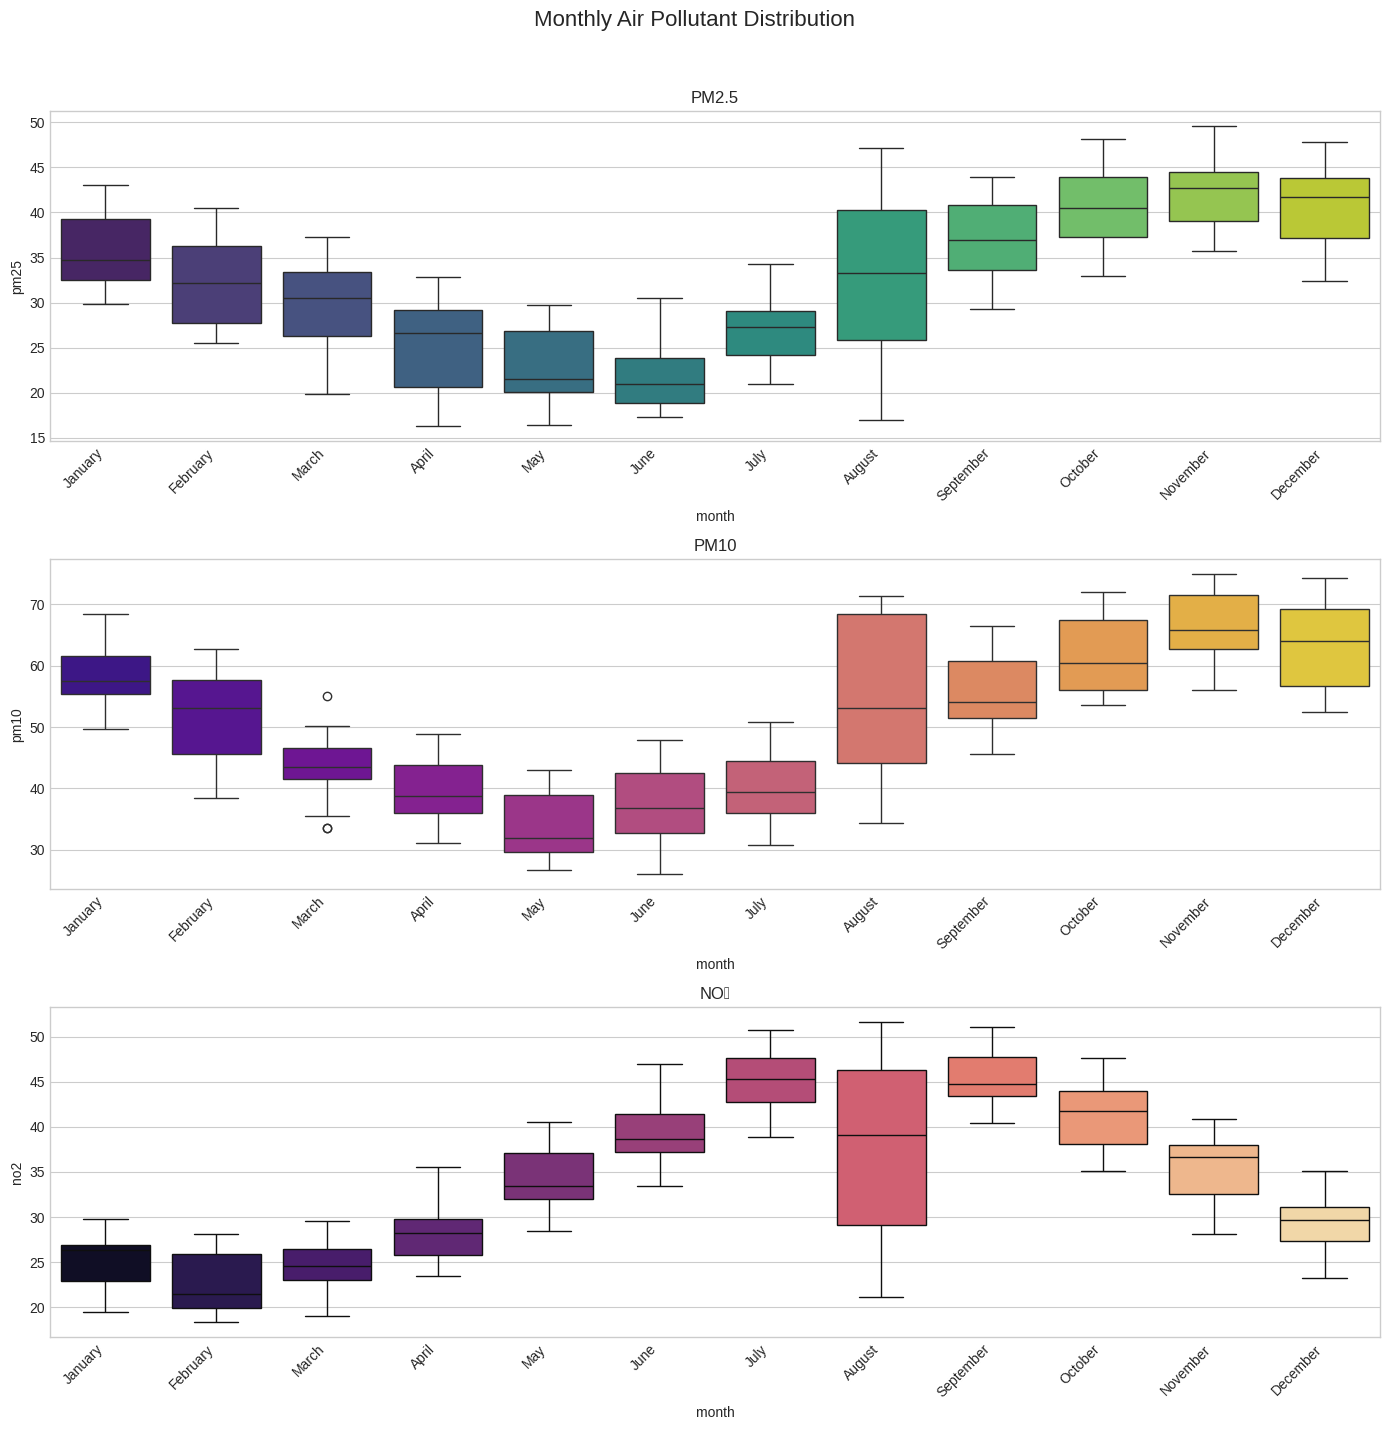

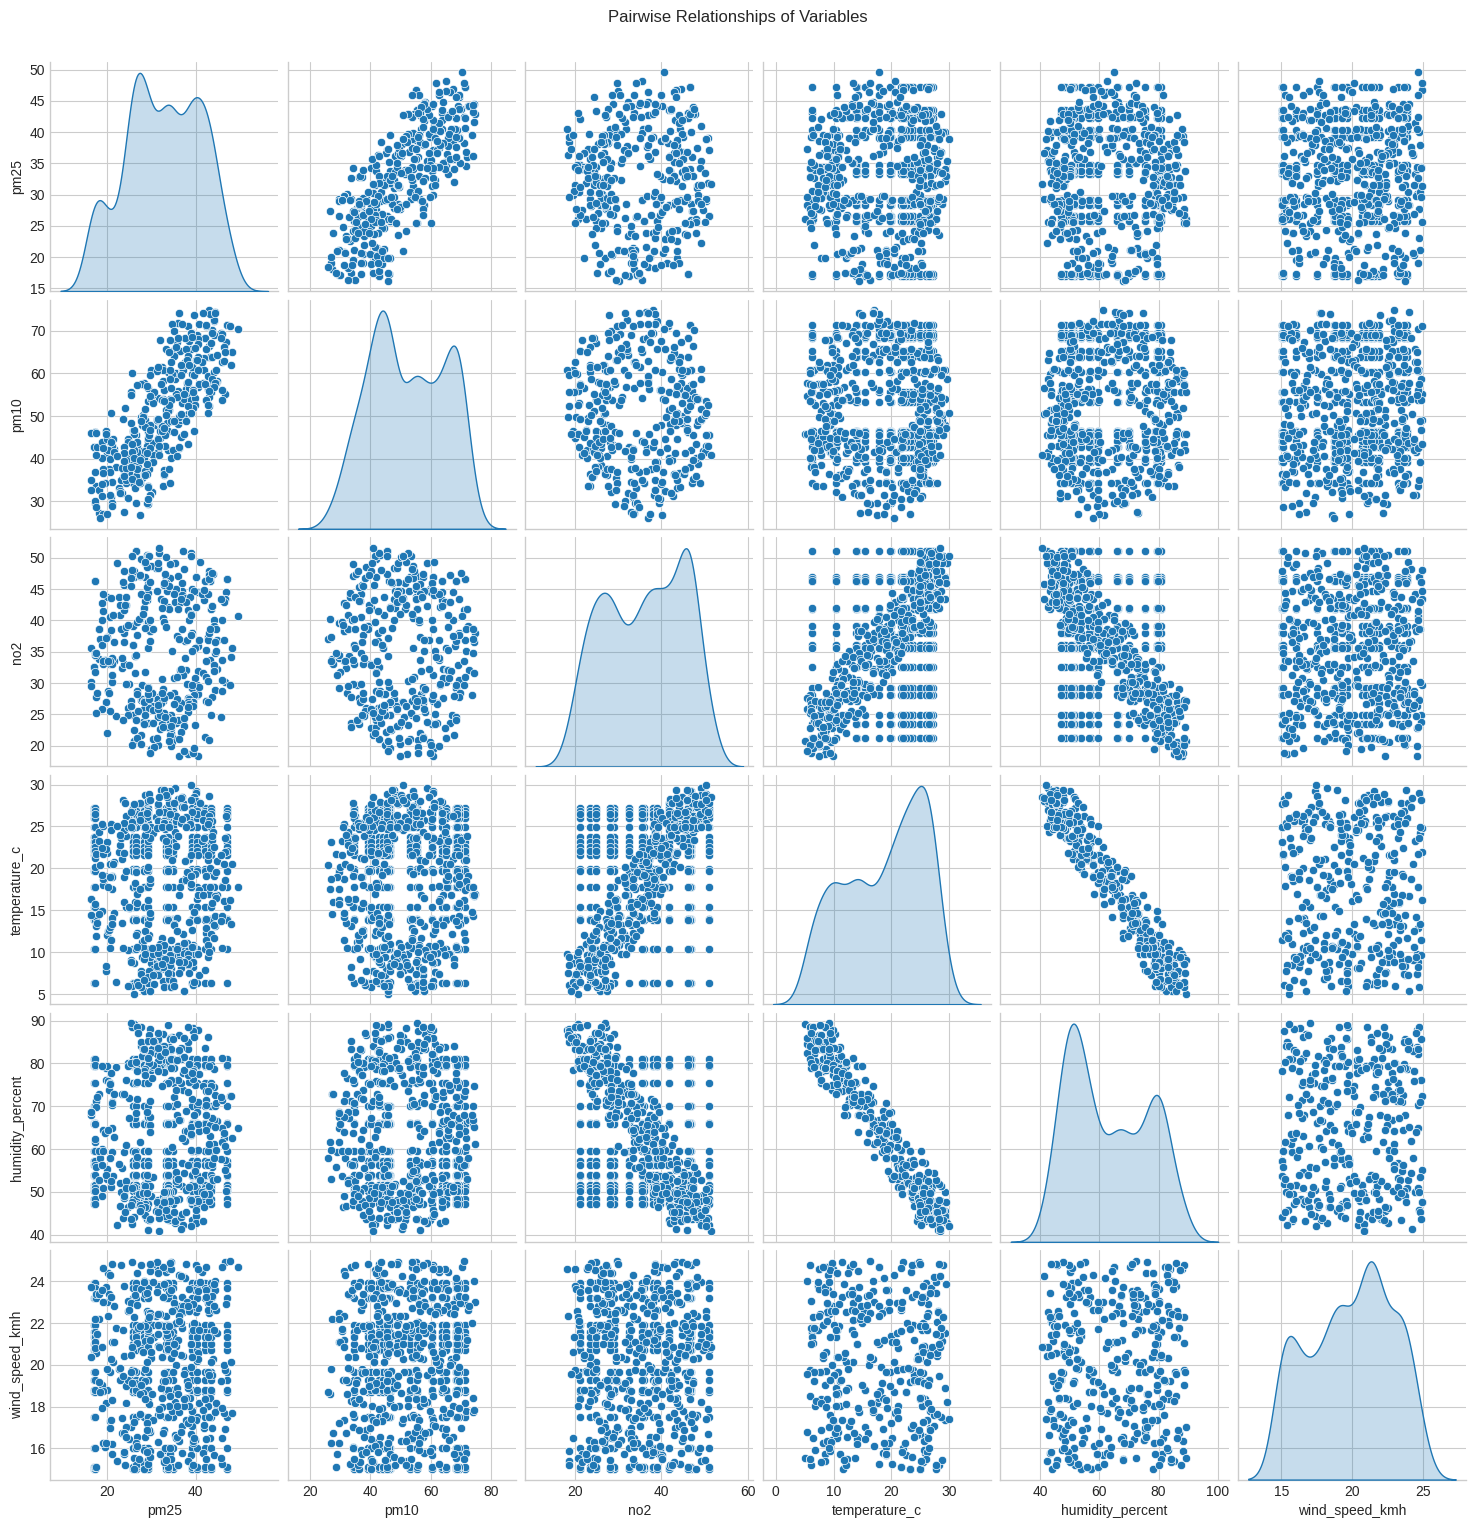

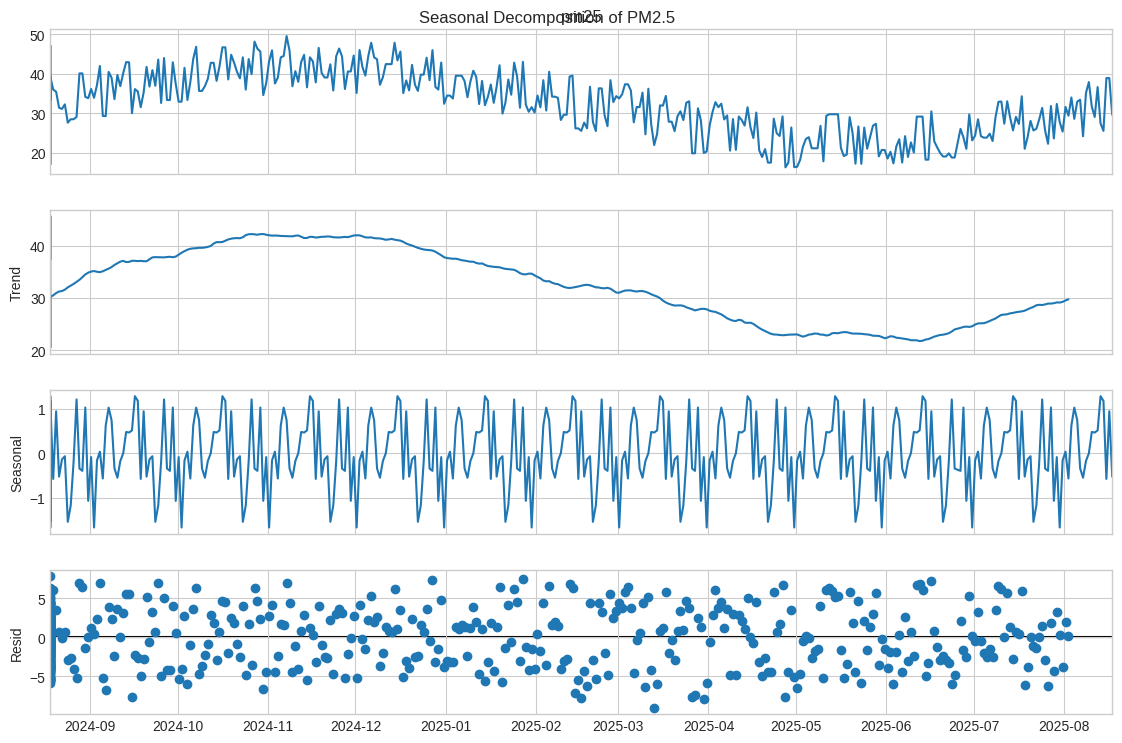

 Linear Regression Results (PM2.5 vs. Weather)
Intercept: 23.0318
Coefficients:
  - temperature_c: 0.1827
  - humidity_percent: 0.0932
  - wind_speed_kmh: 0.0154
R-squared: 0.0019
-----


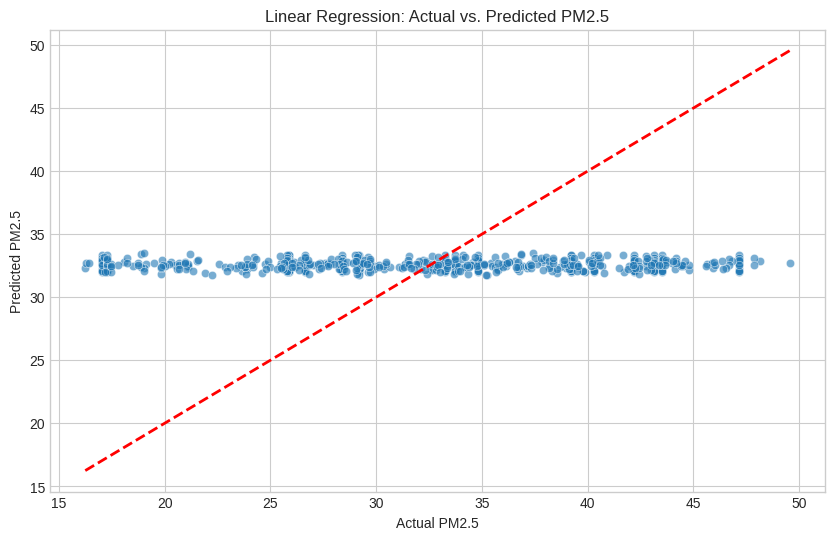

In [19]:
air_quality_df, weather_df = generate_sample_data()
df = clean_and_prepare_data(air_quality_df, weather_df)
df.head()

plt.style.use('seaborn-v0_8-whitegrid')
variables_to_plot = ['pm25', 'pm10', 'no2', 'temperature_c', 'humidity_percent', 'wind_speed_kmh']

df[variables_to_plot].hist(bins=20, figsize=(15, 10), layout=(2, 3))
plt.suptitle('Distribution of Air Quality and Weather Variables', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()



fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
fig.suptitle(f'Air Quality Pollutant Trends in {LOCATION_CITY}', fontsize=16)

pollutants = {'pm25': 'royalblue', 'pm10': 'forestgreen', 'no2': 'darkorange'}
titles = {'pm25': 'PM2.5 Levels (µg/m³)', 'pm10': 'PM10 Levels (µg/m³)', 'no2': 'NO₂ Levels (µg/m³)'}

for i, (pollutant, color) in enumerate(pollutants.items()):
    df[pollutant].plot(ax=axes[i], title=titles[pollutant], color=color, alpha=0.5, label='Daily Value')
    df[pollutant].rolling(window=30).mean().plot(ax=axes[i], color=color, label='30-Day Rolling Avg')
    axes[i].set_ylabel('Concentration (µg/m³)')
    axes[i].legend()

plt.xlabel('Date')
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()


correlation_matrix = df[variables_to_plot].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix: Air Quality vs. Weather')
plt.show()


df_monthly = df.copy()
df_monthly['month'] = df_monthly.index.month_name()
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df_monthly['month'] = pd.Categorical(df_monthly['month'], categories=months_order, ordered=True)

fig, axes = plt.subplots(3, 1, figsize=(14, 15))
fig.suptitle('Monthly Air Pollutant Distribution', fontsize=16)
sns.boxplot(x='month', y='pm25', data=df_monthly, ax=axes[0], palette='viridis').set_title('PM2.5')
sns.boxplot(x='month', y='pm10', data=df_monthly, ax=axes[1], palette='plasma').set_title('PM10')
sns.boxplot(x='month', y='no2', data=df_monthly, ax=axes[2], palette='magma').set_title('NO₂')

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

pairplot_fig = sns.pairplot(df[variables_to_plot], diag_kind='kde')
pairplot_fig.fig.suptitle('Pairwise Relationships of Variables', y=1.02)
plt.show()


result_pm25 = seasonal_decompose(df['pm25'], model='additive', period=30) # Assume monthly seasonality
fig = result_pm25.plot()
fig.set_size_inches(12, 8)
fig.suptitle('Seasonal Decomposition of PM2.5', y=0.95)
plt.show()

X = df[['temperature_c', 'humidity_percent', 'wind_speed_kmh']]
y = df['pm25']

model = LinearRegression()
model.fit(X, y)

df['predicted_pm25'] = model.predict(X)

print(" Linear Regression Results (PM2.5 vs. Weather)")
print(f"Intercept: {model.intercept_:.4f}")
print("Coefficients:")
for feature, coef in zip(X.columns, model.coef_):
    print(f"  - {feature}: {coef:.4f}")
print(f"R-squared: {model.score(X, y):.4f}")
print("-----")

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y, y=df['predicted_pm25'], alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='red', linewidth=2) # Perfect prediction line
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title('Linear Regression: Actual vs. Predicted PM2.5')
plt.show()

In [20]:


print("Creating geographic map...")
avg_pm25 = df['pm25'].mean()

m = folium.Map(location=LOCATION_COORDS, zoom_start=12)

folium.Circle(
    location=LOCATION_COORDS,
    radius=avg_pm25 * 50,
    popup=f'<b>{LOCATION_CITY}</b><br>Avg PM2.5: {avg_pm25:.2f} µg/m³',
    color='crimson',
    fill=True,
    fill_color='crimson',
    fill_opacity=0.6
).add_to(m)

m

print("\n Summary of Findings ")
print(f"Analysis conducted for {LOCATION_CITY} over the past year.")

pm25_change = ((df['pm25'][-1] - df['pm25'][0]) / df['pm25'][0]) * 100
print(f"\n1. Trends: Overall, PM2.5 levels showed a change of {pm25_change:.2f}% over the period.")
print("   Seasonal patterns were observed, with different pollutants peaking at different times of the year.")

corr = df[['pm25', 'temperature_c', 'humidity_percent']].corr()
temp_corr = corr.loc['pm25', 'temperature_c']
humidity_corr = corr.loc['pm25', 'humidity_percent']
print(f"\n2. Correlations: PM2.5 showed a correlation of {temp_corr:.2f} with temperature and {humidity_corr:.2f} with humidity.")
print("   This suggests a potential relationship between weather conditions and air pollution levels.")

print("\n3. Modeling: A linear regression model was built to predict PM2.5 based on weather variables.")
print("   This model can help in understanding the quantitative impact of meteorological factors on air quality.")

print("\n4. Actionable Insights: The identified patterns could inform public health advisories during high-pollution seasons.")
print("   Further analysis could focus on specific pollution events and their causes.")
print("------\n")


Creating geographic map...

 Summary of Findings 
Analysis conducted for Luton, UK over the past year.

1. Trends: Overall, PM2.5 levels showed a change of -11.08% over the period.
   Seasonal patterns were observed, with different pollutants peaking at different times of the year.

2. Correlations: PM2.5 showed a correlation of 0.01 with temperature and 0.01 with humidity.
   This suggests a potential relationship between weather conditions and air pollution levels.

3. Modeling: A linear regression model was built to predict PM2.5 based on weather variables.
   This model can help in understanding the quantitative impact of meteorological factors on air quality.

4. Actionable Insights: The identified patterns could inform public health advisories during high-pollution seasons.
   Further analysis could focus on specific pollution events and their causes.
------



/tmp/ipython-input-3891528777.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pm25_change = ((df['pm25'][-1] - df['pm25'][0]) / df['pm25'][0]) * 100
